In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')





### Etapa de exploração ### 
Vamos começar selecionando possíveis features que fariam sentido alterar o preço de uma casa na vida real:  
 
MSSubClass - Classe da construção (possui 15 valores numéricos distintos, vale a pena investigar)  ✅  

MSZoning - Classificação geral da Zona (possui 5 valores categóricos distintos) ✅  

LotFrontage: - Metros lineares de rua conectados à propriedade (Talvez uma propriedade de esquina possua um valor maior, para identificar uma casa de esquina talvez a razão entre LotFrontage e LotArea seja útil) ✅  

LotArea: Tamanho do lote em pés quadrados (Variável claramente útil, mas importante tomar cuidado com multicolinearidade devido a outras features associadas ao tamanho do lote, talvez um tratamento de lasso seja necessário) ✅  



Alley: Tipo de acesso ao beco (Parecido com a variável acima mas com valores nulos majoritários) 

LotShape: Forma geral da propriedade (talvez terrenos mais regulares possuam valor maior? ✅ 

LandContour: Planicidade da propriedade (A maioria é próxima a um terreno regular, mas barrancos e grandes declives podem influenciar fortemente nos preços das casas) ✅  



LotConfig: Configuração do lote (lote interno, lote de esquina, sem saída, fechado em 2 lados, fechado em 3 lados
(certamente temos oportunidade de transformar essa variável em algo ordinal ao entender a valoração em relação a cada tipagem) ✅ 

LandSlope: Inclinação da propriedade (mesmo com valores majoritários como 'leve inclinação' talvez seja o motivo de possíveis outliers, vale investigar) ✅ 



Condition1: Proximidade de várias condições (Variável super interessante, informa se a casa é próxima a rua de alimentação, parques, rodovias, como se tratam de apenas 9 categorias pode nos ajudar a criar uma variável para entender o quão bem localizada é a casa, mas é bem desbalanceada, provavelmente não estará entre nossas features principais, caso utilizada de forma isolada) ✅ 

Condition2: Acréscimo a Condition1 ✅

BldgType: Tipo de moradia (Moradias como duplex podem acabar tendo valor maior que as feitas para uma única família) ✅  

HouseStyle: Estilo de moradia(Quantidade de andares) ✅  

OverallQual: Avalia o material e finalização da casa ✅ 

OverallCond: Condição geral da casa ✅  
(Podemos fazer o produto de ambas acima)

YearRemodAdd: Data da reforma, igual da construção se não houver reforma ou acréscimos ✅


MiscVal: Valor de recursos diversos, como elevador, segunda garagem ✅

Para esse estudo vamos utilizar essas features para tentar montar nosso dataset de treinamento!



In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
X_train = train_data[['MSSubClass', 'MSZoning', 
                                   'LotArea', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 
                                   'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
                                   'YearRemodAdd', 'ExterCond', 'MiscVal']]
y_train = train_data[['SalePrice']]

In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   MSSubClass    1460 non-null   int64 
 1   MSZoning      1460 non-null   object
 2   LotArea       1460 non-null   int64 
 3   LotShape      1460 non-null   object
 4   LandContour   1460 non-null   object
 5   LotConfig     1460 non-null   object
 6   LandSlope     1460 non-null   object
 7   Condition1    1460 non-null   object
 8   Condition2    1460 non-null   object
 9   BldgType      1460 non-null   object
 10  HouseStyle    1460 non-null   object
 11  OverallQual   1460 non-null   int64 
 12  OverallCond   1460 non-null   int64 
 13  YearRemodAdd  1460 non-null   int64 
 14  ExterCond     1460 non-null   object
 15  MiscVal       1460 non-null   int64 
dtypes: int64(6), object(10)
memory usage: 182.6+ KB


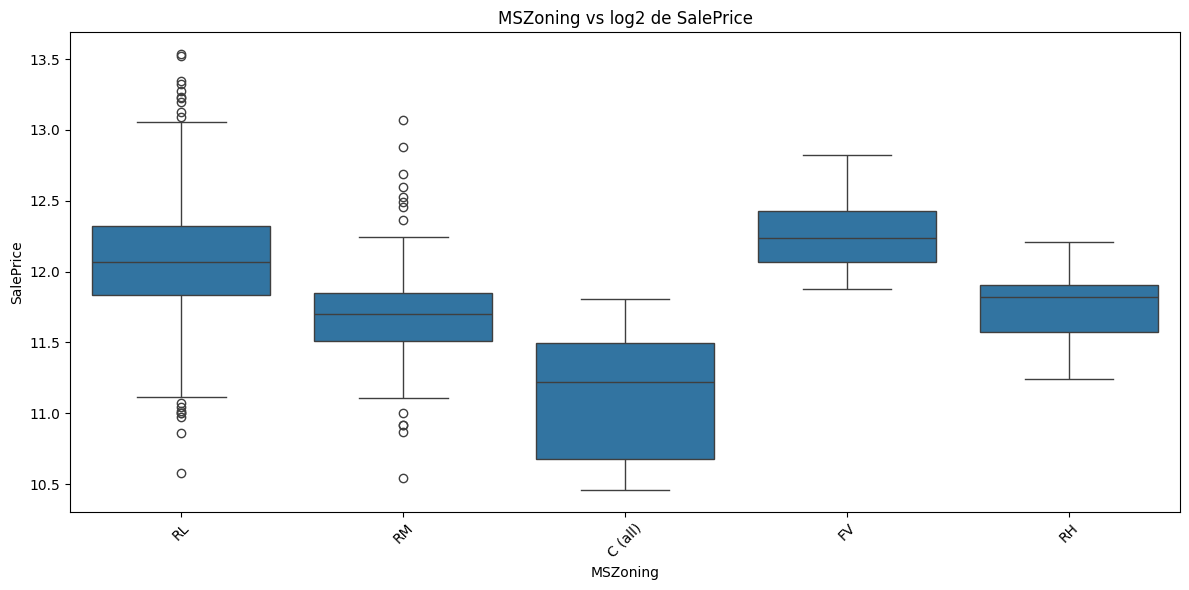

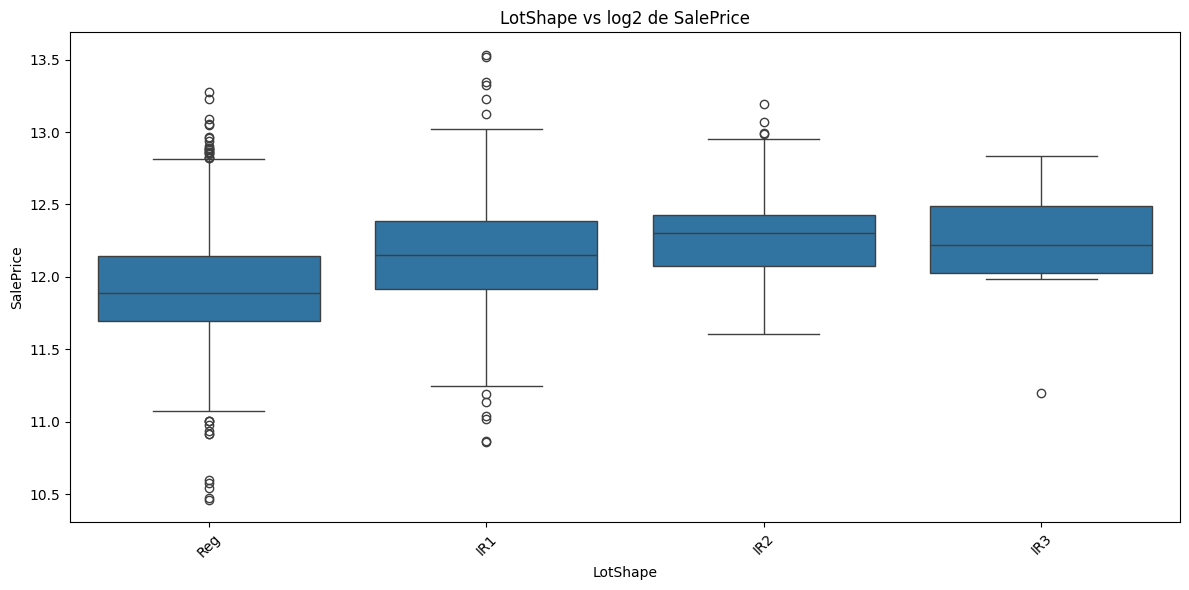

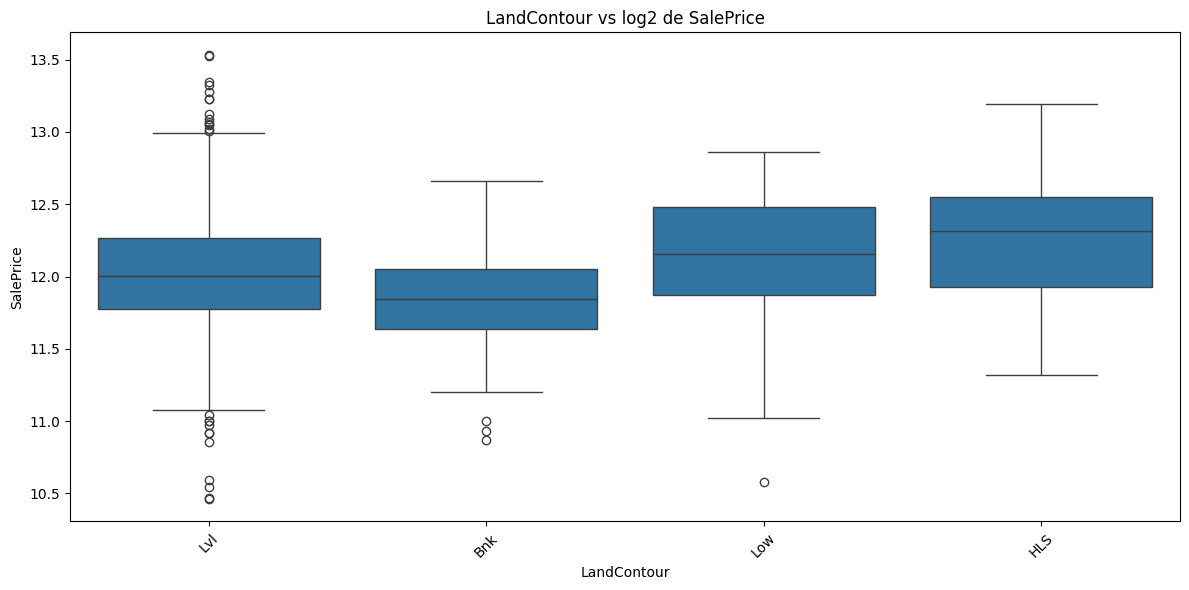

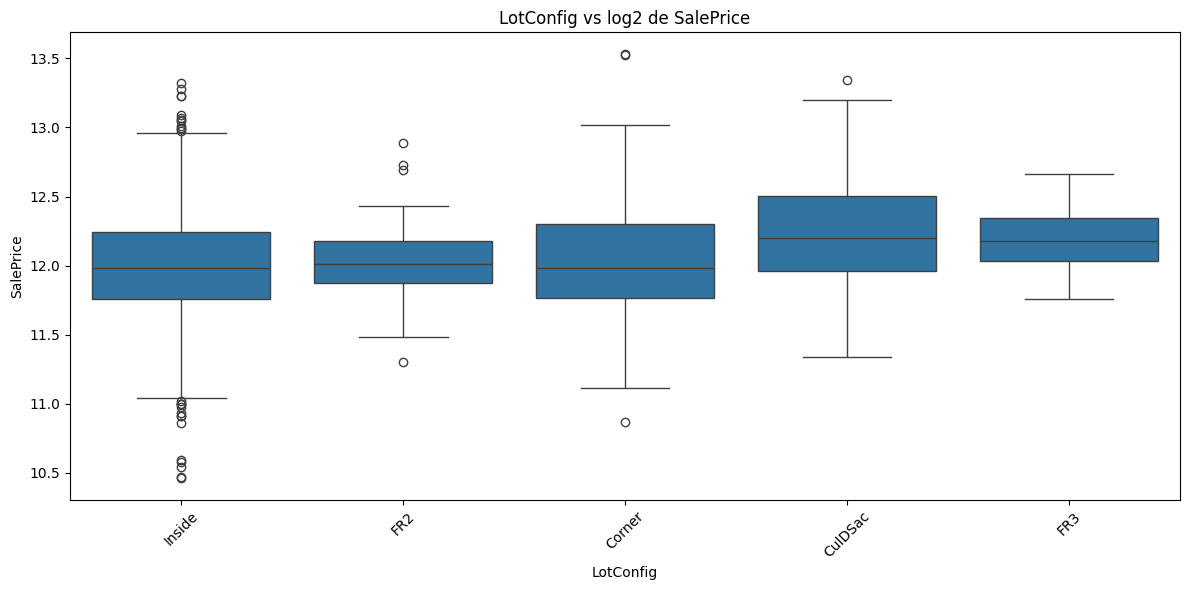

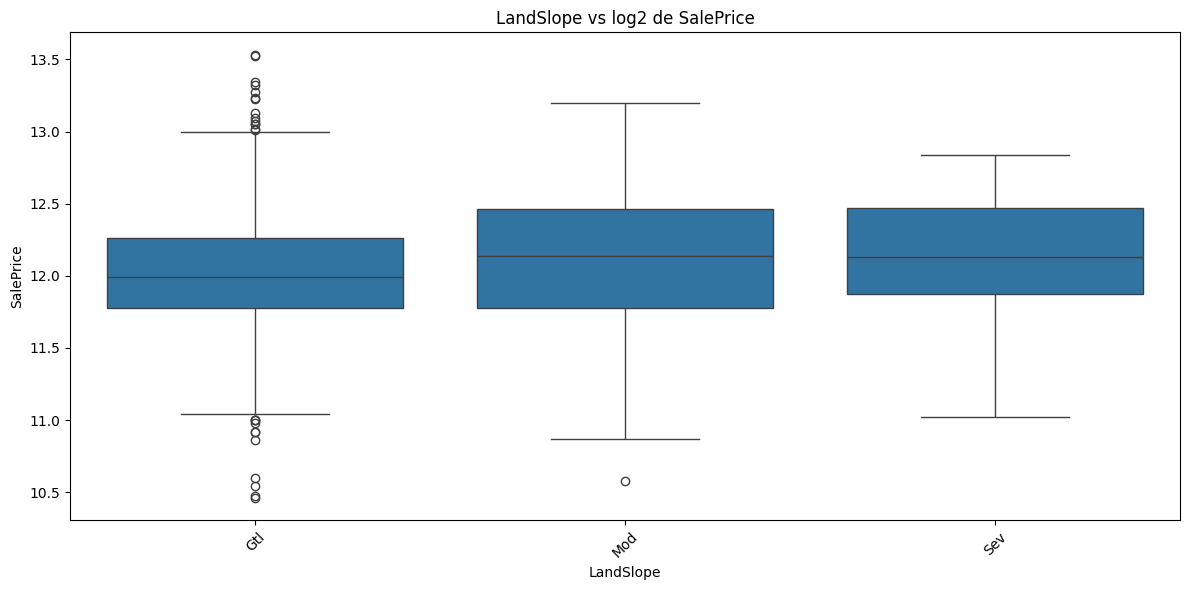

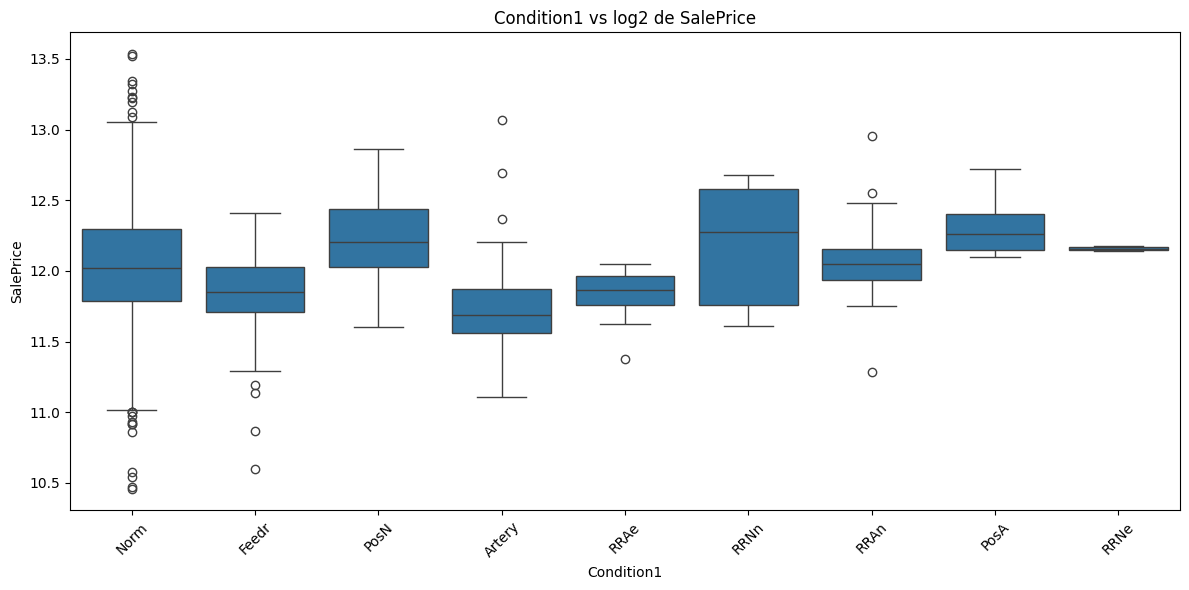

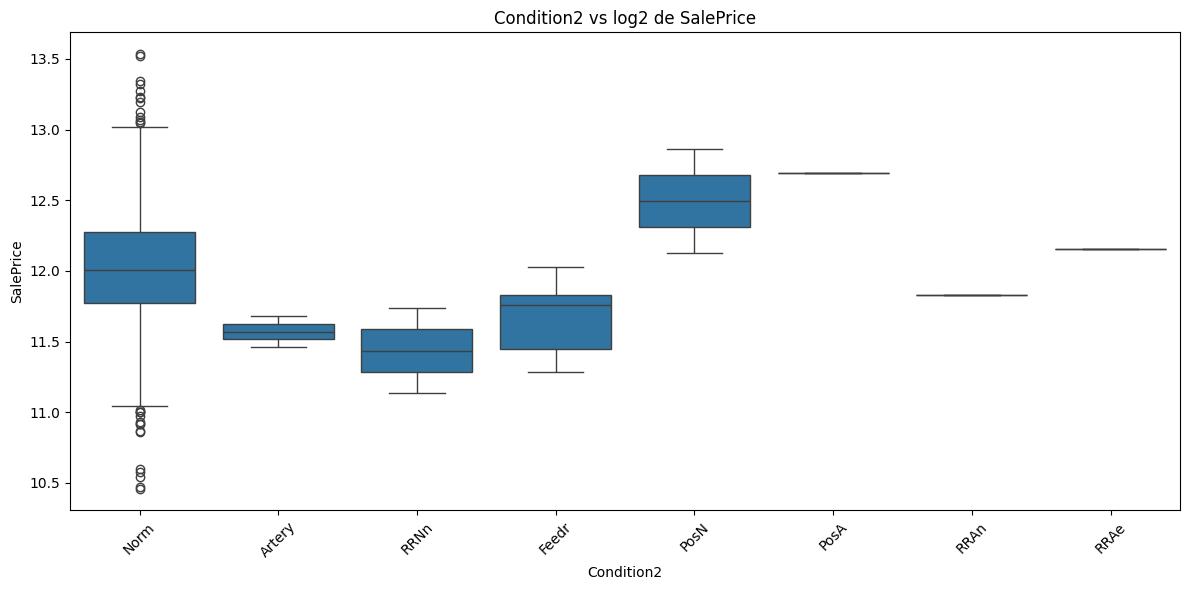

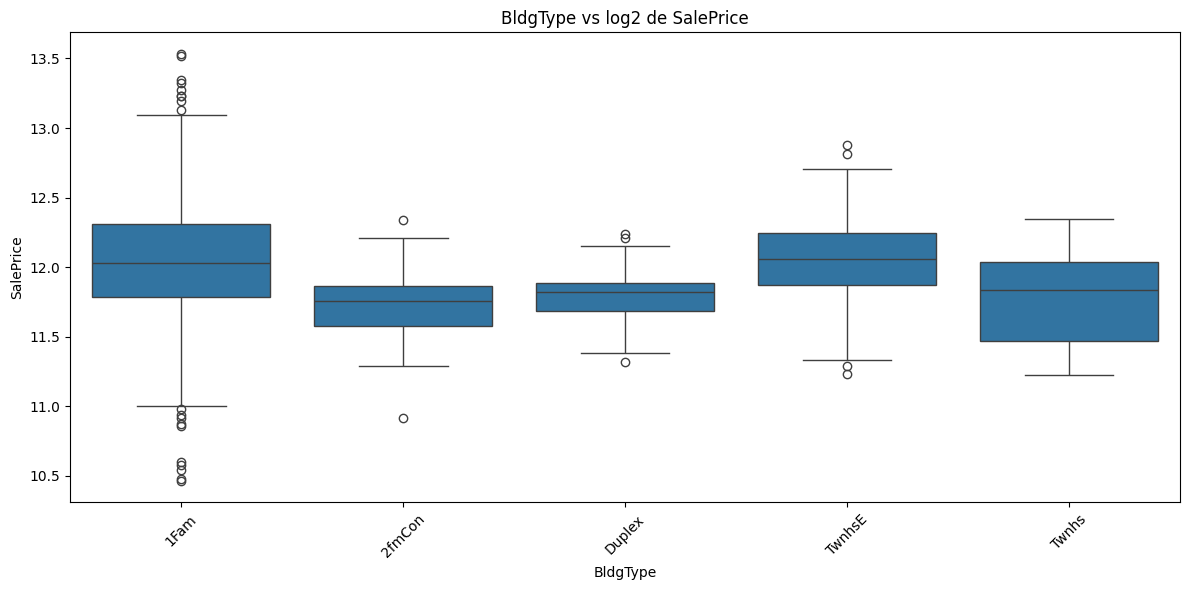

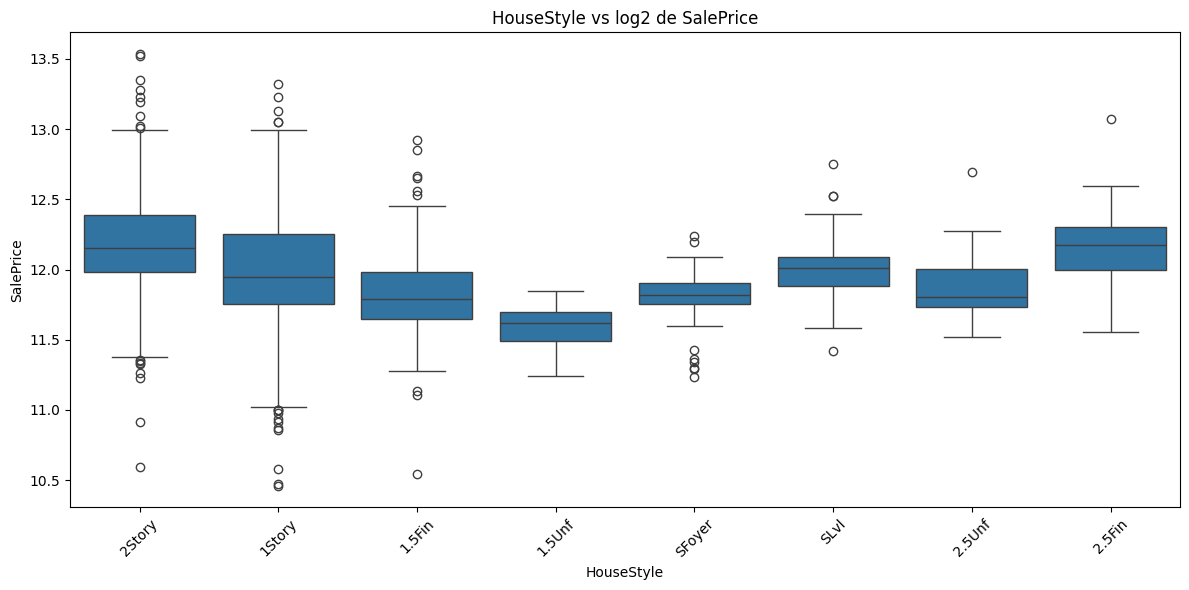

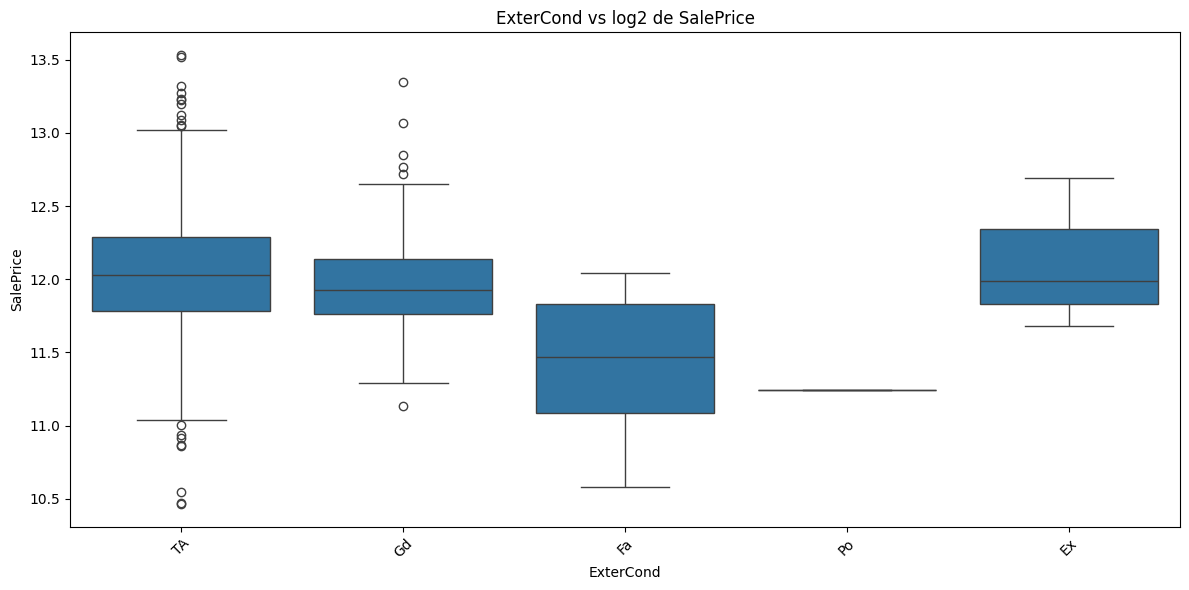

In [6]:
# 1. Selecionar colunas do tipo object
categorical_cols = X_train.select_dtypes(include='object').columns

# 2. Loop por cada coluna categórica para plotar boxplot
for col in categorical_cols:
    # Se muitas categorias, pula (opcional)
    if train_data[col].nunique() > 15:
        print(f"Pulando {col} (muitas categorias: {train_data[col].nunique()})")
        continue

    plt.figure(figsize=(12, 6))
    sns.boxplot(data=train_data, x=col, y=np.log1p(train_data['SalePrice']))
    plt.xticks(rotation=45)
    plt.title(f'{col} vs log2 de SalePrice')
    plt.tight_layout()
    plt.show()


Variáveis Ordinais, nominais
Ordinais: 
Alley ['Grvl', 'Pave'] -> [0,1]
LotShape ['Reg', 'IR1', 'IR2', 'IR3'] -> [3,2,1,0]
LandCountour['Lvl', 'Bnk', 'HLS', 'Low'] -> [3,2,1,0]

Nominais: MSZoning ['RL','RM', 'FV', 'RH', 'C (all)']



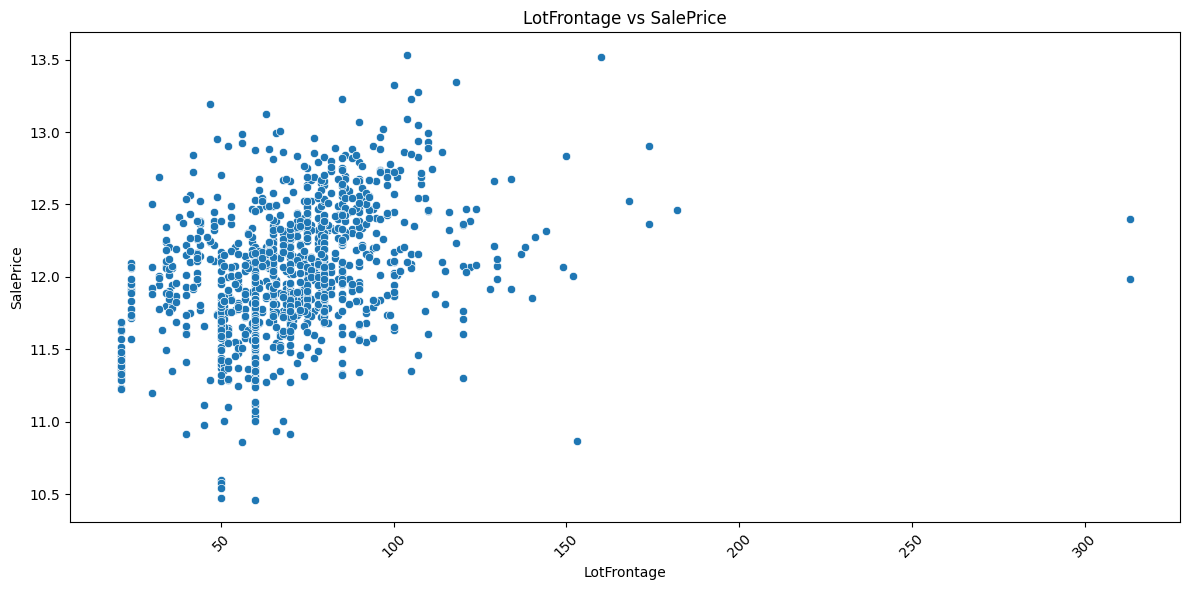

In [7]:
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=train_data, x=train_data['LotFrontage'], y=np.log1p(train_data['SalePrice']))
    plt.xticks(rotation=45)
    plt.title(f'LotFrontage vs SalePrice')
    plt.tight_layout()
    plt.show()


In [8]:
#Removi algumas variáveis que percebi não ter um padrão de comportante perceptível ou pouquíssimas amostras
X_train = train_data[['MSSubClass', 'MSZoning', 
                                   'LotArea', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 
                                   'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
                                   'YearRemodAdd', 'ExterCond', 'MiscVal', 'YrSold']]

In [9]:
# Converte MSSubClass para string (categoria)
X_train['MSSubClass'] = X_train['MSSubClass'].astype(str)

# Combina Condition1 e Condition2:
conditions = set(X_train['Condition1'].unique()) | set(X_train['Condition2'].unique())
conditions = [c for c in conditions if c is not None]  # garante valores válidos
for cond in conditions:
    X_train[f'Cond_{cond}'] = ((X_train['Condition1'] == cond) | (X_train['Condition2'] == cond)).astype(int)

# Remove as colunas originais de Condition1/2
X_train = X_train.drop(['Condition1','Condition2'], axis=1)

# Aplica One-hot encoding nas variáveis nominais restantes (incluindo as novas Cond_*): https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html
nominal_cols = ['MSSubClass','MSZoning','LandContour','LotConfig',
                'BldgType','HouseStyle']  # Condition já transformada
df_nominal = pd.get_dummies(X_train[nominal_cols], drop_first=True)  # drop_first para evitar dummy trap
df_nominal.columns[:5]  # visualizar algumas colunas dummy geradas


C:\Users\Jorge\AppData\Local\Temp\ipykernel_19796\1033295113.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['MSSubClass'] = X_train['MSSubClass'].astype(str)
C:\Users\Jorge\AppData\Local\Temp\ipykernel_19796\1033295113.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[f'Cond_{cond}'] = ((X_train['Condition1'] == cond) | (X_train['Condition2'] == cond)).astype(int)
C:\Users\Jorge\AppData\Local\Temp\ipykernel_19796\1033295113.py:8: SettingWithCopyWarning: 
A value is trying to be set on

Index(['MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSSubClass_20',
       'MSSubClass_30'],
      dtype='object')

In [10]:
# Mapeei manualmente as variáveis ordinais:
lotshape_map = {'IR3': 1, 'IR2': 2, 'IR1': 3, 'Reg': 4}
landslope_map = {'Sev': 1, 'Mod': 2, 'Gtl': 3}
extercond_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

X_train['LotShape_enc'] = X_train['LotShape'].map(lotshape_map)
X_train['LandSlope_enc'] = X_train['LandSlope'].map(landslope_map)
X_train['ExterCond_enc'] = X_train['ExterCond'].map(extercond_map)

# Dropamos as demais que serão inutilizadas:
X_train = X_train.drop(['LotShape','LandSlope','ExterCond'], axis=1)


In [11]:
# Exemplo: aplicar transformação logarítmica a LotArea e MiscVal
X_train['LotArea_log'] = np.log1p(X_train['LotArea'])
X_train['MiscVal_log'] = np.log1p(X_train['MiscVal'])

# Criar indicador binário para MiscVal > 0
X_train['HasMiscFeature'] = (X_train['MiscVal'] > 0).astype(int)

# (Opcional) Criar YearsSinceRemodel se YrSold estiver disponível:
if 'YrSold' in X_train.columns:
    X_train['YearsSinceRemodel'] = X_train['YrSold'] - X_train['YearRemodAdd']


In [12]:
X_train = X_train.drop(['LotArea','MiscVal'], axis=1)


In [13]:
numeric_cols = ['LotArea_log','YearRemodAdd','YearsSinceRemodel',
                'MiscVal_log','OverallQual','OverallCond']  # incluir as que desejar padronizar
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])


In [14]:
# Selecionar apenas colunas numéricas (após encoding final)
numeric_df = X_train.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

# Exibir a matriz de correlação para uma ideia geral
print(corr_matrix[['OverallQual','OverallCond','LotArea_log','YearsSinceRemodel']].round(2))


                   OverallQual  OverallCond  LotArea_log  YearsSinceRemodel
OverallQual               1.00        -0.09         0.18              -0.55
OverallCond              -0.09         1.00        -0.01              -0.07
YearRemodAdd              0.55         0.07         0.03              -1.00
YrSold                   -0.03         0.04        -0.03               0.03
Cond_PosN                 0.05         0.01         0.05               0.01
Cond_Norm                 0.01        -0.05        -0.03              -0.02
Cond_PosA                 0.05         0.09         0.08              -0.02
Cond_RRNe                 0.01         0.01         0.00              -0.02
Cond_RRAe                -0.04         0.00         0.04              -0.01
Cond_RRNn                 0.01         0.02        -0.01              -0.01
Cond_RRAn                 0.02        -0.00         0.06              -0.03
Cond_Artery              -0.07         0.08         0.01               0.17
Cond_Feedr  

In [15]:
#Optei por utilizar a variável que criamos 'YearsSinceRemodel'
X_train = X_train.drop(['YearRemodAdd'], axis=1)


In [16]:
# Montar matriz de features (já processadas) e adicionar intercepto para cálculo do VIF
X = X.fillna(0)  # garantir sem NA
X = sm.add_constant(X)  # add intercept constant

vif_series = pd.Series(
    [variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
    index=X.columns
)
print(vif_series.sort_values(ascending=False))


NameError: name 'X' is not defined

In [ ]:
# Produto de OverallQual e OverallCond, como dissemos lá em cima a ideia é combinar as variáveis de qualidade
X_train['OverallQualCond'] = X_train['OverallQual'] * X_train['OverallCond']



In [ ]:
df = pd.concat([X_train, df_nominal], axis=1)
df.drop(nominal_cols, axis=1, inplace=True)  # se quiser remover as colunas originais


In [ ]:


# X: dataframe de features final, y: variável alvo (SalePrice)
X = df.drop('SalePrice', axis=1, errors='ignore')
y = np.log1p(train_data['SalePrice'])  # supondo que ainda estejamos com o conjunto de treino e temos SalePrice

# 6.1 LassoCV para encontrar alpha ótimo e selecionar features
lasso_cv = LassoCV(cv=5, random_state=42).fit(X, y)
print(f"Alpha ótimo escolhido: {lasso_cv.alpha_:.4f}")
coef = pd.Series(lasso_cv.coef_, index=X.columns)
# Features selecionadas pelo Lasso (coeficiente != 0):
selected_by_lasso = list(coef[coef != 0].index)
print(f"Features selecionadas pelo Lasso: {selected_by_lasso}")

# 6.2 Random Forest feature importances
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=X.columns)
print("Top 10 features por importância (Random Forest):")
print(importances.sort_values(ascending=False).head(10))


Alpha ótimo escolhido: 0.0003
Features selecionadas pelo Lasso: ['OverallQual', 'OverallCond', 'YrSold', 'Cond_Artery', 'Cond_PosN', 'Cond_Feedr', 'Cond_RRAe', 'Cond_RRAn', 'Cond_Norm', 'LotShape_enc', 'LandSlope_enc', 'ExterCond_enc', 'LotArea_log', 'MiscVal_log', 'YearsSinceRemodel', 'OverallQualCond', 'MSSubClass_180', 'MSSubClass_190', 'MSSubClass_30', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_90', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'LandContour_HLS', 'LandContour_Lvl', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_Inside', 'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'HouseStyle_1Story', 'HouseStyle_2.5Fin', 'HouseStyle_2.5Unf', 'HouseStyle_2Story', 'HouseStyle_SFoyer']
Top 10 features por importância (Random Forest):
OverallQual          0.655333
LotArea_log          0.118201
YearsSinceRemodel    0.065468
MSZoning_RM          0.020602
OverallQualCond      0.018945
YrSold               0.015112
MSSubClass

Alpha muito pequeno (próximo de 0):

O modelo se comporta como uma regressão linear comum (quase sem regularização).

Muitos coeficientes continuam diferentes de zero.

Pode indicar que as variáveis estão todas contribuindo ou que o dataset é pequeno demais para precisar de regularização forte.

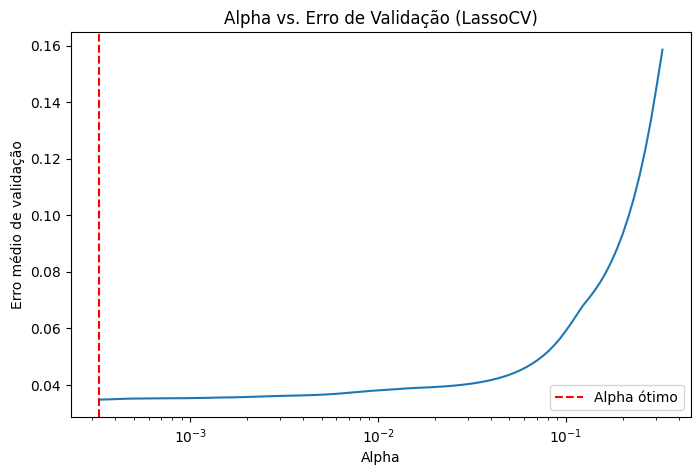

In [ ]:
alphas = lasso_cv.alphas_  # valores testados
mse_path = lasso_cv.mse_path_.mean(axis=1)

plt.figure(figsize=(8, 5))
plt.plot(alphas, mse_path)
plt.axvline(lasso_cv.alpha_, linestyle='--', color='red', label='Alpha ótimo')
plt.xlabel('Alpha')
plt.ylabel('Erro médio de validação')
plt.xscale('log')
plt.legend()
plt.title('Alpha vs. Erro de Validação (LassoCV)')
plt.show()


In [ ]:
train_data['MSZoning'].nunique()

NameError: name 'train_data' is not defined

In [27]:
X_train['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [29]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC